In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Dataset/'Genetic Attribution' 
!ls



Mounted at /gdrive
/gdrive/My Drive/Dataset/Genetic Attribution
catboost_info	gene1.csv  model.png	    train_feat.csv    train_values.csv
dna2vec		gene.csv   submission.csv   train_labels.csv
embed_5mer.npy	LightGBM   test_values.csv  train_seq.npz


In [2]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#!pip install catboost
!pip install biopython
#https://drive.google.com/drive/u/1/folders/1aBYLZq1yijVJBkgwUukPMN9kFuulGQMj
import gzip
import pandas as pd
#from catboost import CatBoostClassifier
from keras.models import Model
import keras.layers as L
from keras.utils import to_categorical, plot_model
import keras
import os
import sys
from keras import layers, models, optimizers
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras import regularizers
import gc
from urllib.request import urlretrieve
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle

import Bio
from Bio import SeqIO, SearchIO, Entrez
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.Blast import NCBIWWW
from Bio.Data import CodonTable

print("Python version:", sys.version_info)
print("Biopython version:", Bio.__version__)
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from itertools import permutations


     |████████████████████████████████| 2.3MB 8.7MB/s 
Python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
Biopython version: 1.78


In [4]:

train_values=pd.read_csv('train_values.csv')
train_labels=pd.read_csv('train_labels.csv')
test_values=pd.read_csv('test_values.csv')
submission=pd.read_csv('submission.csv')
#loaded = np.load('train_seq.npz')
#train_sequence=loaded['a']

embedding_matrix=np.load('embed_5mer.npy')
train_values.head()

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:

#train_data=pd.DataFrame(count_dict)
train_data=pd.DataFrame()

train_data=pd.concat([train_values,train_data],axis=1)

target_cols=train_labels.columns[1:]
target=[]

tmmp=train_labels[target_cols]
for val in range(train_labels.shape[0]):
  tmp=tmmp.iloc[val].values
  target.append(target_cols[np.argmax(tmp)])
train_labels['target']=target
train_labels=train_labels[['sequence_id','target']]


train_data=pd.merge(train_data,train_labels,on='sequence_id')
train_data['target']=LabelEncoder().fit_transform(train_data['target'])
target_cols=train_labels.columns[1:]




In [6]:
bases = set(''.join(train_values.sequence.values))
bases.remove('N')
subsequences = [''.join(permutation) for permutation in permutations(bases, r=4)]

def get_ngram_features(data, subsequences):
    features = pd.DataFrame(index=data.index)
    for subseq in subsequences:
        #subseq=subseq.replace('N','')
        features[subseq] = data.sequence.str.count(subseq)
    return features

def top10_accuracy_scorer(preds, classes,y):
    top10_idx = np.argpartition(preds, -10, axis=1)[:, -10:]
    top10_preds=classes[top10_idx]
    mask = top10_preds == y.reshape((y.size, 1))
    top_10_accuracy = mask.any(axis=1).mean()
    return top_10_accuracy
    
def kmers(seq, k):
  v = []
  for i in range(len(seq) - k + 1):
    v.append(seq[i:i + k])
  return v


ngram_features_train = get_ngram_features(train_values, subsequences)
ngram_features_test = get_ngram_features(test_values, subsequences)
train_data=pd.concat([train_data,ngram_features_train],axis=1)
test_values=pd.concat([test_values,ngram_features_test],axis=1)

In [7]:
%%time
##Clear N-base out of the genetic sequence
max_seq_len=8000;train_sequence=[];test_sequence=[];count=0
gc.collect()

for val in train_values.sequence.values:
  val=val.replace('N','')
  val=kmers(val,4)
  train_sequence.append(val)
  count+=1
  if count%10000==0:
    print(count)
gc.collect()

10000
20000
30000
40000
50000
60000
CPU times: user 55.5 s, sys: 7.01 s, total: 1min 2s
Wall time: 1min 2s


In [8]:
%%time
## convert the genetic sequence into sentence datatype
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sequence)
train_sequence = tokenizer.texts_to_sequences(train_sequence)
train_sequence=np.array(train_sequence)



for val in test_values.sequence.values:
  val=val.replace('N','')
  val=kmers(val,4)
  test_sequence.append(val)

tokenizer.fit_on_texts(test_sequence)
test_sequence = tokenizer.texts_to_sequences(test_sequence)
test_sequence=np.array(test_sequence)

data = pad_sequences(train_sequence, maxlen=max_seq_len,padding='post')
test_sequence = pad_sequences(test_sequence, maxlen=max_seq_len,padding='post')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


CPU times: user 4min 57s, sys: 5.8 s, total: 5min 3s
Wall time: 5min 3s


In [9]:
%%time
## convert the sequence into image datatype

def get_seq_img(df,max_seq_len=8000):
  all_img=[];pad_size=48;
  for i in range(df.shape[0]):
    tmp=list(df.iloc[i].sequence)
    tmp1=Seq(df.sequence.values[i])
    tmp_count=0
    tmp1=list(tmp1.reverse_complement())
    #print(len(tmp1),len(tmp))
    tmp_dict=dict(zip(['A','G','C','T'],[np.zeros(max_seq_len*2+pad_size,dtype=np.uint8) for val in range(4)]))
    for j in range(len(tmp)):
      if j==max_seq_len:
        break
      if tmp[j]=='N':
        continue
      else:
        tmp_dict[tmp[j]][tmp_count]=1
      if tmp1[j]=='N':
        continue
      else:
        tmp_dict[tmp1[j]][tmp_count+max_seq_len+pad_size]=1
      tmp_count+=1

    v=[]
    for keys in tmp_dict.keys():
        v.append(tmp_dict[keys])
    yield (np.array(v))
  #return all_img
tmp_img=get_seq_img(train_values)
train_images=[]
for i,img in enumerate(tmp_img):
  train_images.append(img)

tmp_img=get_seq_img(test_values)
test_images=[]
for i,img in enumerate(tmp_img):
  test_images.append(img)

np.sum(train_images[0])

CPU times: user 3min 52s, sys: 1.51 s, total: 3min 54s
Wall time: 3min 54s


In [10]:
test_sequence=np.array(test_sequence)
test_sequence=test_sequence.reshape((test_sequence.shape[0],1,test_sequence.shape[1]))


### data prep

In [12]:
## Create N-fold validation data split
is_train_seq=True;is_train_img=True;is_train=True
cols2_drop=['sequence_id','sequence','target']
folds=5;
n_fold_train=dict(zip(np.arange(folds),[dict(zip(['train_seq','train_img','train','target'],[[],[],[],[]])) for val in range(folds)]))
#train_images, train_target, train_data1 = shuffle(train_images,train_data.target.values,train_data.drop(columns=cols2_drop).values, random_state=42)
train_sequence,train_images, train_target, train_data1 = shuffle(train_sequence,train_images,train_data.target.values,train_data.drop(columns=cols2_drop).values, random_state=42)
train_images=np.array(train_images)
index=np.arange(0,train_values.shape[0]-1,int(train_values.shape[0]/folds))
for i in range(folds):
  if is_train_img==True:
    n_fold_train[i]['train_img']=train_images[index[i]:index[i+1]]
  if is_train_seq==True:
    n_fold_train[i]['train_seq']=data[index[i]:index[i+1]]
  if is_train==True:
    n_fold_train[i]['train']=train_data1[index[i]:index[i+1]]
  n_fold_train[i]['target']=np.array(train_target[index[i]:index[i+1]])
del train_sequence,train_images
gc.collect()


0

In [13]:
## this function returns the data for single fold based on fold choice.
def get_data(n_fold_train,fold=1,tot_folds=5,is_train_seq=True,is_train_img=True,is_train=True):
  train_X_img=[];train_X_seq=[];train_X=[];val_X_img=[];val_X=[];val_X_seq=[];val_y=[];train_y=[]
  for i in range(tot_folds):
    if is_train_img==True:
      if i==fold:
        val_X_img=np.array(n_fold_train[i]['train_img'])
      else:
        train_X_img.append(n_fold_train[i]['train_img'])
    if is_train_seq==True:

      if i==fold:
        val_X_seq=n_fold_train[i]['train_seq']
      else:
        train_X_seq.append(n_fold_train[i]['train_seq'])
    if is_train==True:
      if i==fold:
        val_X=n_fold_train[i]['train']
      else:
        train_X.append(n_fold_train[i]['train'])
    if i==fold:
        val_y=np.array(n_fold_train[i]['target'])
    else:
        train_y.append(n_fold_train[i]['target'])
  train_X_img=np.array(train_X_img)
  train_X_seq=np.array(train_X_seq)
  train_X=np.array(train_X)
  train_y=np.array(train_y)
  print((train_X_img).shape)
  if is_train_img==True:
    train_X_img=train_X_img.reshape(val_X_img.shape[0]*(folds-1),4,val_X_img.shape[-1])
  if is_train_seq==True:
    train_X_seq=train_X_seq.reshape(val_X_seq.shape[0]*(folds-1),val_X_seq.shape[1])
  if is_train==True:
    train_X=train_X.reshape(val_X.shape[0]*(folds-1),val_X.shape[1])
  train_y=train_y.reshape(train_y.shape[1]*(folds-1),1)
  print(np.squeeze(train_y).shape)
  
  return train_X,train_X_img,train_X_seq,val_X,val_X_img,val_X_seq,np.squeeze(train_y),val_y

### models

In [14]:
def reduce_mem_usage(df):
    
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [15]:
 ## sequence + df model
def create_mpl1(shape):
    '''
    Returns a keras model
    '''
    print("bb")
    X_input2 = L.Input((1,max_seq_len))
    X1 = L.Embedding(len(tokenizer.word_index) + 1,weights=[embedding_matrix],output_dim=100,input_length=max_seq_len,trainable=False)(X_input2)
    X1 = L.Conv1D(8, 3,padding='same')(X1)
    X1 = L.PReLU()(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.Dropout(0.7)(X1)
    
    X1 = L.Conv1D(8, 3,dilation_rate=2,padding='same')(X1)
    X1 = L.PReLU()(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.Dropout(0.5)(X1)
    X1 = L.Flatten()(X1)

    X1 = L.Dense(512, activation='relu')(X1)
    X1 = L.BatchNormalization()(X1)
    X1 = L.Dropout(0.5)(X1)


    X_input1 = L.Input(shape)
    print("aa")
    X = L.Dense(512, activation='relu')(X_input1)
    X = L.Dropout(0.5)(X)
    X = L.Concatenate(axis=1)([X,X1])
    X = L.Dense(2048, activation='relu')(X)#,kernel_regularizer=regularizers.l2(0.001))(X)
    X = L.BatchNormalization()(X)
    X = L.Dense(1314, activation='softmax')(X)
    
    model = Model(inputs=[X_input1,X_input2],outputs=X)
    print(shape)
    return model
def get_model_seq():
  cols2_drop=['sequence_id','sequence','target']

  mlp = create_mpl1(train_data.drop(columns=cols2_drop).shape[1])
  loss_fn = keras.losses.SparseCategoricalCrossentropy()
  mlp.compile(optimizer='adam', loss=loss_fn, metrics=['sparse_categorical_accuracy'])
  #print(mlp.summary())
  return mlp
mlp=get_model_seq()


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0009)
class_weights = dict(zip(np.unique(train_data['target'].values),class_weight.compute_class_weight(None,np.unique(train_data['target'].values),train_data['target'].values)))


bb
aa
63


In [16]:
## sequence + df + img model
 
def create_mpl(shape):
  print("bb")
  X_input2 = L.Input((1,max_seq_len))
  X1 = L.Embedding(len(tokenizer.word_index) + 1,weights=[embedding_matrix],output_dim=100,input_length=max_seq_len,trainable=False)(X_input2)
  X1 = L.Conv1D(8, 3,dilation_rate=1,padding='same')(X1)
  X1 = L.PReLU()(X1)
  X1 = L.BatchNormalization()(X1)
  X1 = L.Dropout(0.8)(X1)
  X1 = L.Conv1D(8, 3,dilation_rate=2,padding='same')(X1)
  X1 = L.PReLU()(X1)
  X1 = L.BatchNormalization()(X1)
  X1 = L.Dropout(0.8)(X1)
  X1 = L.Flatten()(X1)
  X1 = L.Dense(512, activation='relu')(X1)
  X1 = L.BatchNormalization()(X1)
  X1 = L.Dropout(0.7)(X1)

    #####################################################
  X_input1 = L.Input(shape)
  print("aa")
  X = L.Dense(256, activation='relu')(X_input1)
  X = L.BatchNormalization()(X)
  X = L.Dropout(0.5)(X)
  X = L.Dense(1024, activation='relu')(X)
  X = L.BatchNormalization()(X)
  X = L.Dropout(0.6)(X)

    ##########################################################
  X_input3 = L.Input((n_fold_train[0]['train_img'][0].shape))
  X2 = L.Conv1D(64, 3,padding='same')(X_input3)
  X2 = L.PReLU()(X2)
  X2 = L.BatchNormalization()(X2)
  X2 = L.Dropout(0.7)(X2)
  X2 = L.Flatten()(X2)
  X2 = L.Dense(512, activation='relu')(X2)
  X2 = L.BatchNormalization()(X2)
  X2 = L.Dropout(0.6)(X2)

  
    ###########################################################
  X_seq = L.Concatenate(axis=1)([X2,X1])
  X = L.Concatenate(axis=1)([X,X_seq])
  X = L.Dense(2048, activation='relu')(X)
  X = L.BatchNormalization()(X)
  X = L.Dense(1314, activation='softmax')(X)
    
  model = Model(inputs=[X_input1,X_input2,X_input3],outputs=X)
  print(shape)
  return model


def get_model_all():
  cols2_drop=['sequence_id','sequence','target']
  mlp = create_mpl(train_data.drop(columns=cols2_drop).shape[1])
  loss_fn = keras.losses.SparseCategoricalCrossentropy()
  mlp.compile(optimizer='adam', loss=loss_fn, metrics=['sparse_categorical_accuracy'])
  return mlp




class_weights = dict(zip(np.unique(train_data['target'].values),class_weight.compute_class_weight(None,np.unique(train_data['target'].values),train_data['target'].values)))


    

In [17]:
## df + image model

def create_mpl3(shape):
    '''
    Returns a keras model
    '''
    print("bb")
  
    X_input2 = L.Input((n_fold_train[0]['train_img'][0].shape))
    X1 = L.Conv1D(128, 3,padding='same')(X_input2)
    X1 = L.PReLU()(X1)
    X1 = L.BatchNormalization()(X1)

    X1 = L.Dropout(0.8)(X1)
    X1 = L.Conv1D(64, 3,dilation_rate=2,padding='same')(X_input2)
    X1 = L.PReLU()(X1)
    X1 = L.BatchNormalization()(X1)

    X1 = L.Dropout(0.7)(X1)
    X1 = L.Flatten()(X1)
    X1 = L.Dense(256, activation='relu')(X1)
    X1 = L.Dropout(0.5)(X1)

    X1 = L.Dense(512, activation='relu')(X1)
    X1 = L.Dropout(0.6)(X1)


    X_input1 = L.Input(shape)
    print("aa")
    X = L.Dense(256, activation='relu')(X_input1)
    X = L.BatchNormalization()(X)
    X = L.Dropout(0.5)(X)
    X = L.Dense(512, activation='relu')(X_input1)
    X = L.BatchNormalization()(X)
    X = L.Dropout(0.5)(X)
    X = L.Concatenate(axis=1)([X,X1])
    X = L.Dense(2048, activation='relu')(X)#,kernel_regularizer=regularizers.l2(0.001))(X)
    X = L.BatchNormalization()(X)
    X = L.Dense(1314, activation='softmax')(X)
    
    model = Model(inputs=[X_input1,X_input2],outputs=X)
    print(shape)
    return model

def get_model_img():
  cols2_drop=['sequence_id','sequence','target']

  mlp = create_mpl3(train_data.drop(columns=cols2_drop).shape[1])
  loss_fn = keras.losses.SparseCategoricalCrossentropy()
  mlp.compile(optimizer='adam', loss=loss_fn, metrics=['sparse_categorical_accuracy'])

  return mlp



### modeling

************************ Folds : 0 ********************
(4, 12603, 4, 16048)
(50412,)
bb
aa
63
epochs : 15, batch_size : 32
Epoch 1/15
1576/1576 [==============================] - 74s 41ms/step - loss: 5.4509 - sparse_categorical_accuracy: 0.2038 - val_loss: 3.5429 - val_sparse_categorical_accuracy: 0.3922
Epoch 2/15
1576/1576 [==============================] - 64s 41ms/step - loss: 3.7016 - sparse_categorical_accuracy: 0.3504 - val_loss: 2.9485 - val_sparse_categorical_accuracy: 0.4574
Epoch 3/15
1576/1576 [==============================] - 64s 41ms/step - loss: 3.0440 - sparse_categorical_accuracy: 0.4187 - val_loss: 2.5174 - val_sparse_categorical_accuracy: 0.5161
Epoch 4/15
1576/1576 [==============================] - 64s 41ms/step - loss: 2.6049 - sparse_categorical_accuracy: 0.4752 - val_loss: 2.2702 - val_sparse_categorical_accuracy: 0.5590
Epoch 5/15
1576/1576 [==============================] - 64s 41ms/step - loss: 2.2870 - sparse_categorical_accuracy: 0.5151 - val_loss: 2.048

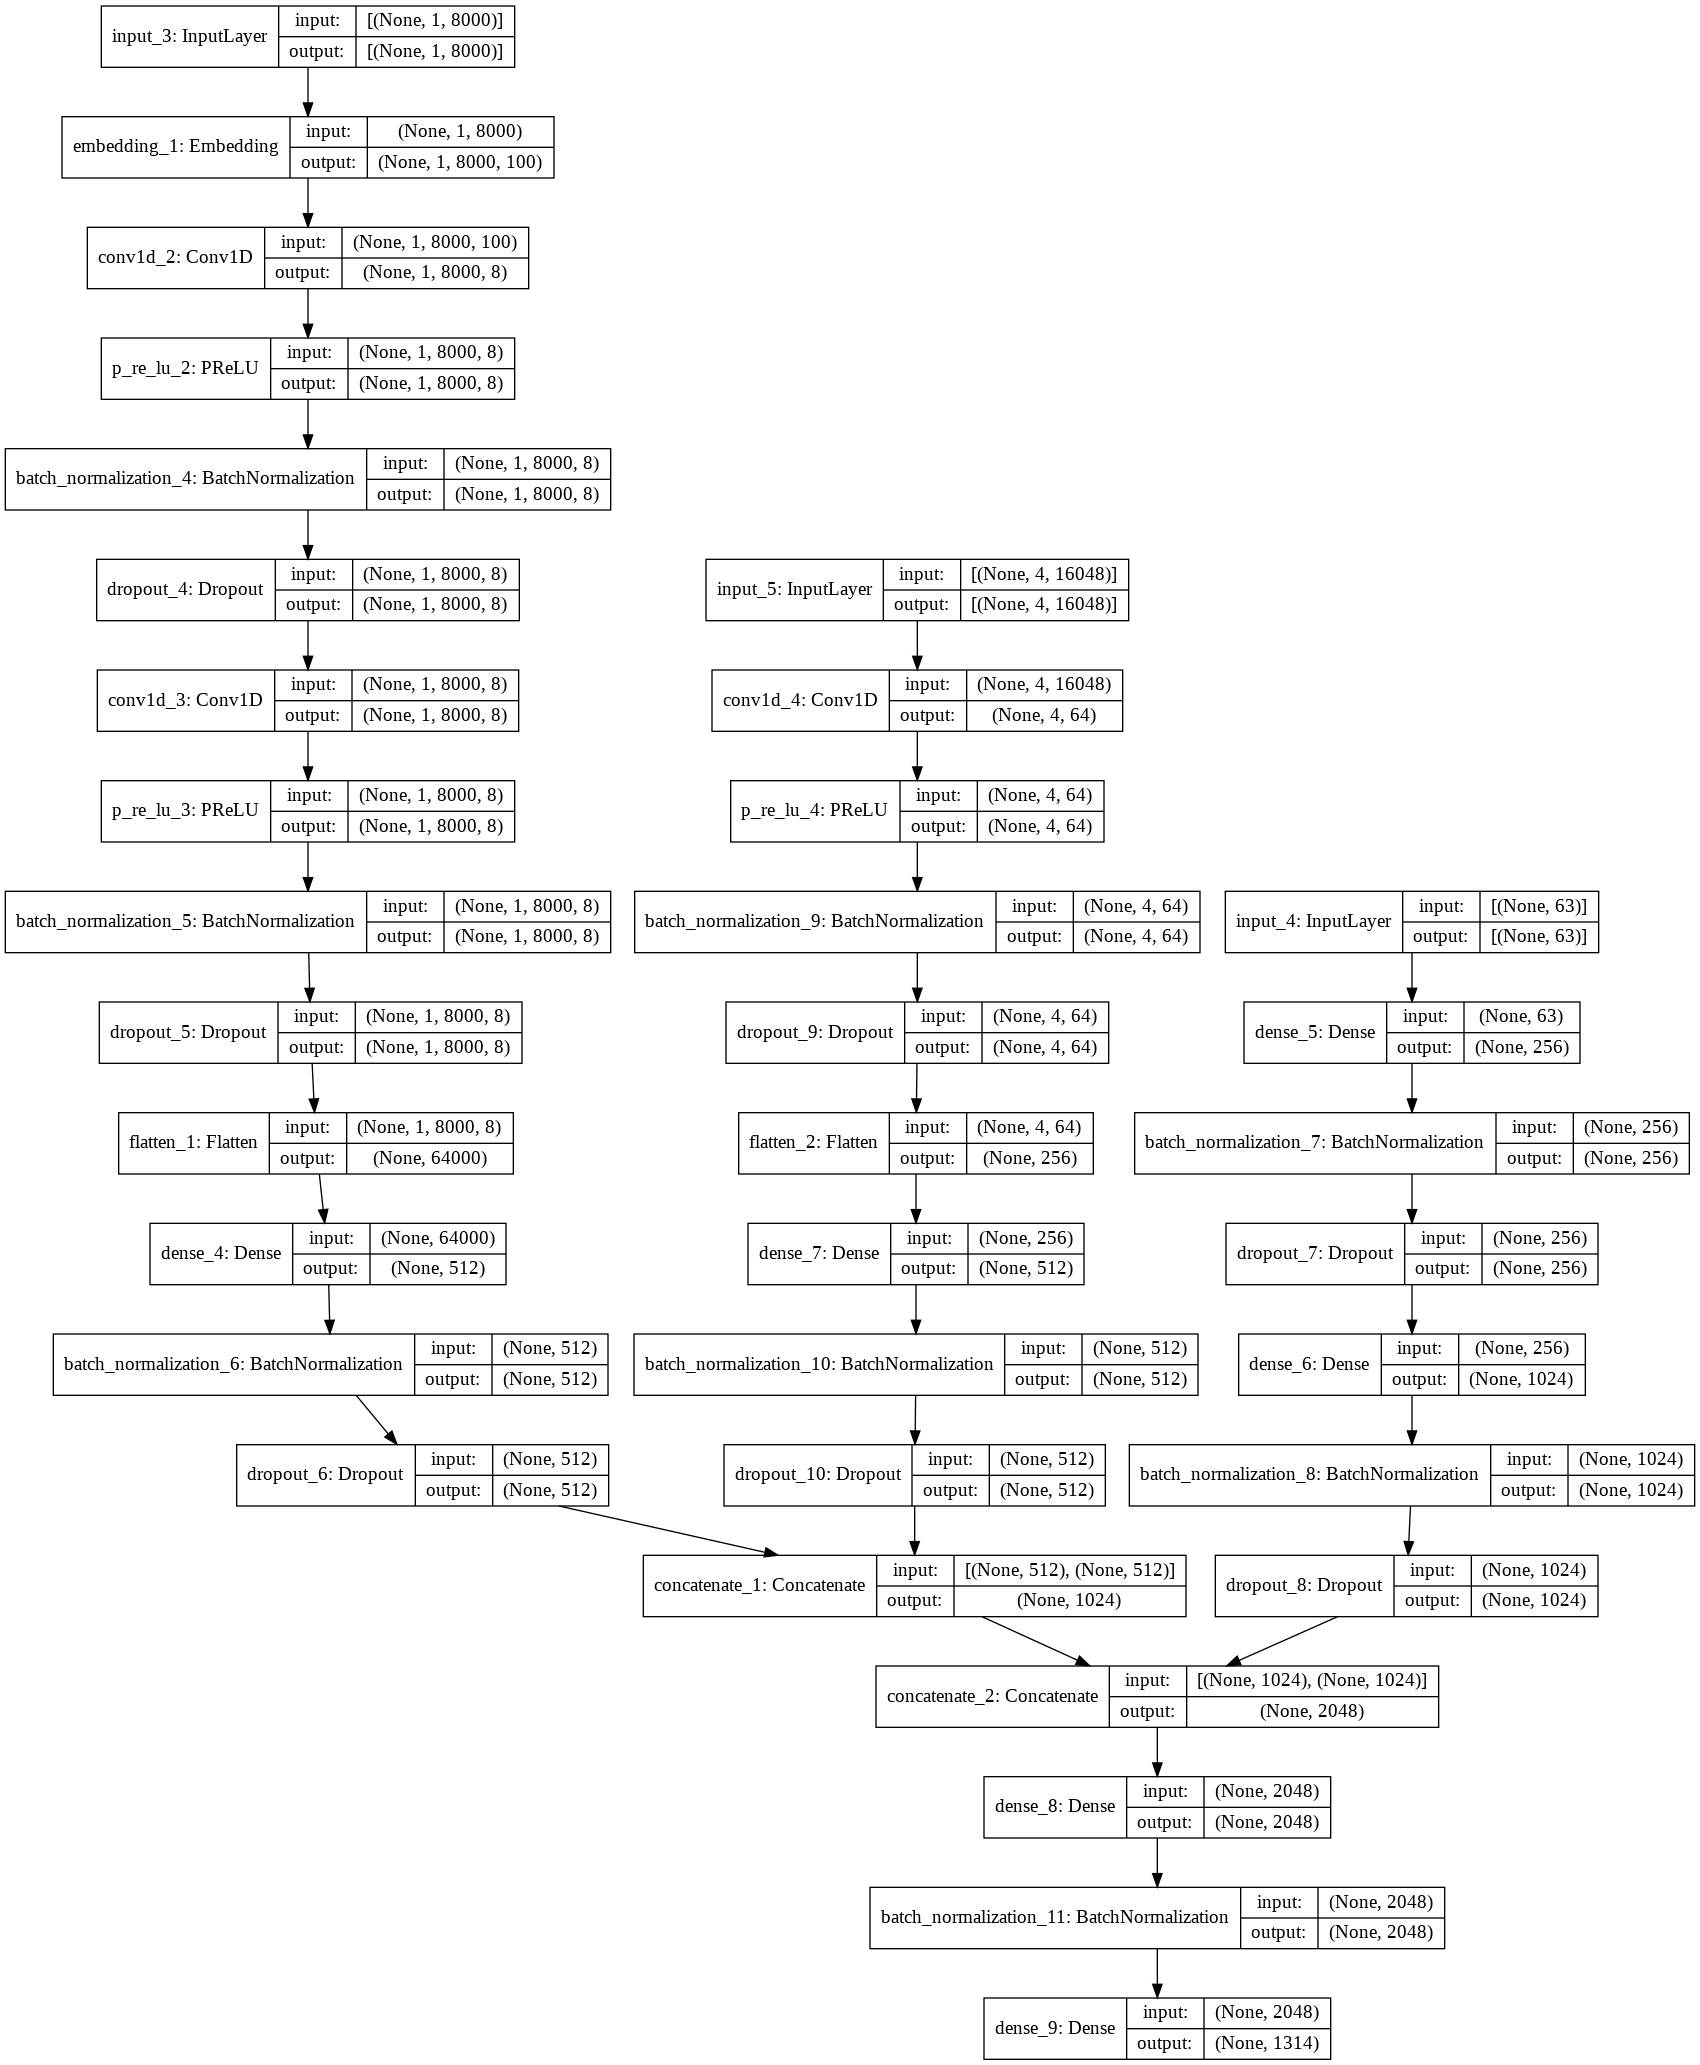

In [18]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.001)
class_weights = dict(zip(np.unique(train_data['target'].values),class_weight.compute_class_weight(None,np.unique(train_data['target'].values),train_data['target'].values)))
output=np.zeros((test_values.shape[0],1314))
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0, patience=3, mode='auto', verbose=1)
epochs_list = [15,5,5]
batch_size_list = [32,64,128] 
for i in range(folds):
  print(f"************************ Folds : {i} ********************")
  is_train_seq=True
  train_X,train_X_img,train_X_seq,val_X,val_X_img,val_X_seq,train_y,val_y=get_data(n_fold_train,fold=i,tot_folds=folds,is_train_seq=True,is_train_img=True,is_train=True)
  if is_train_seq==True:
    train_X_seq=(train_X_seq).reshape((train_X_seq.shape[0],1,train_X_seq.shape[1]))
    val_X_seq=(val_X_seq).reshape((val_X_seq.shape[0],1,val_X_seq.shape[1]))
  mode='all'
  if mode=='all':
    mlp=get_model_all()
  if mode=='seq':
    mlp=get_model_seq()
  if mode=='seq_img':
    mlp=get_model_seq_img()
  if mode=='img':
    mlp=get_model_img()
  
  for epochs, batch_size in zip(epochs_list, batch_size_list):
    print(f"epochs : {epochs}, batch_size : {batch_size}")
    if mode=='all':
      mlp.fit(x=[train_X,train_X_seq,train_X_img], y=train_y, epochs=epochs,validation_data=([val_X,val_X_seq,val_X_img],val_y), batch_size=batch_size, class_weight=class_weights,callbacks=[early_stopping,reduce_lr])
      print("top10_accuracy_scorer",top10_accuracy_scorer(mlp.predict([val_X,val_X_seq,val_X_img]),np.arange(train_data['target'].nunique()),val_y))

    if mode=='seq':
       mlp.fit(x=[train_X,train_X_seq], y=train_y, epochs=epochs,validation_data=([val_X,val_X_seq],val_y), batch_size=batch_size, class_weight=class_weights,callbacks=[early_stopping,reduce_lr])
       print("top10_accuracy_scorer",top10_accuracy_scorer(mlp.predict([val_X,val_X_seq]),np.arange(train_data['target'].nunique()),val_y))

    """if mode=='seq_img':
       mlp.fit(x=[train_X_img,train_X_seq], y=train_y, epochs=epochs,validation_data=([val_X_img,val_X_seq],val_y), batch_size=batch_size, class_weight=class_weights,callbacks=[early_stopping,reduce_lr])
       print("top10_accuracy_scorer",top10_accuracy_scorer(mlp.predict([val_X_img,val_X_seq]),np.arange(train_data['target'].nunique()),val_y))
    """
    if mode=='img':
       mlp.fit(x=[train_X,train_X_img], y=train_y, epochs=epochs,validation_data=([val_X,val_X_img],val_y), batch_size=batch_size, class_weight=class_weights,callbacks=[early_stopping,reduce_lr])
       print("top10_accuracy_scorer",top10_accuracy_scorer(mlp.predict([val_X,val_X_img]),np.arange(train_data['target'].nunique()),val_y))

  #output+=mlp.predict([test_values.drop(columns=['sequence_id', 'sequence']).values,(test_sequence),np.array(test_images)])/folds
  print("dfdf",np.sum(output))
  del train_X,train_X_img,train_X_seq,val_X,val_X_img,val_X_seq,train_y,val_y
  gc.collect()
  break
#plot_model(mlp, show_shapes=True, show_layer_names=True)


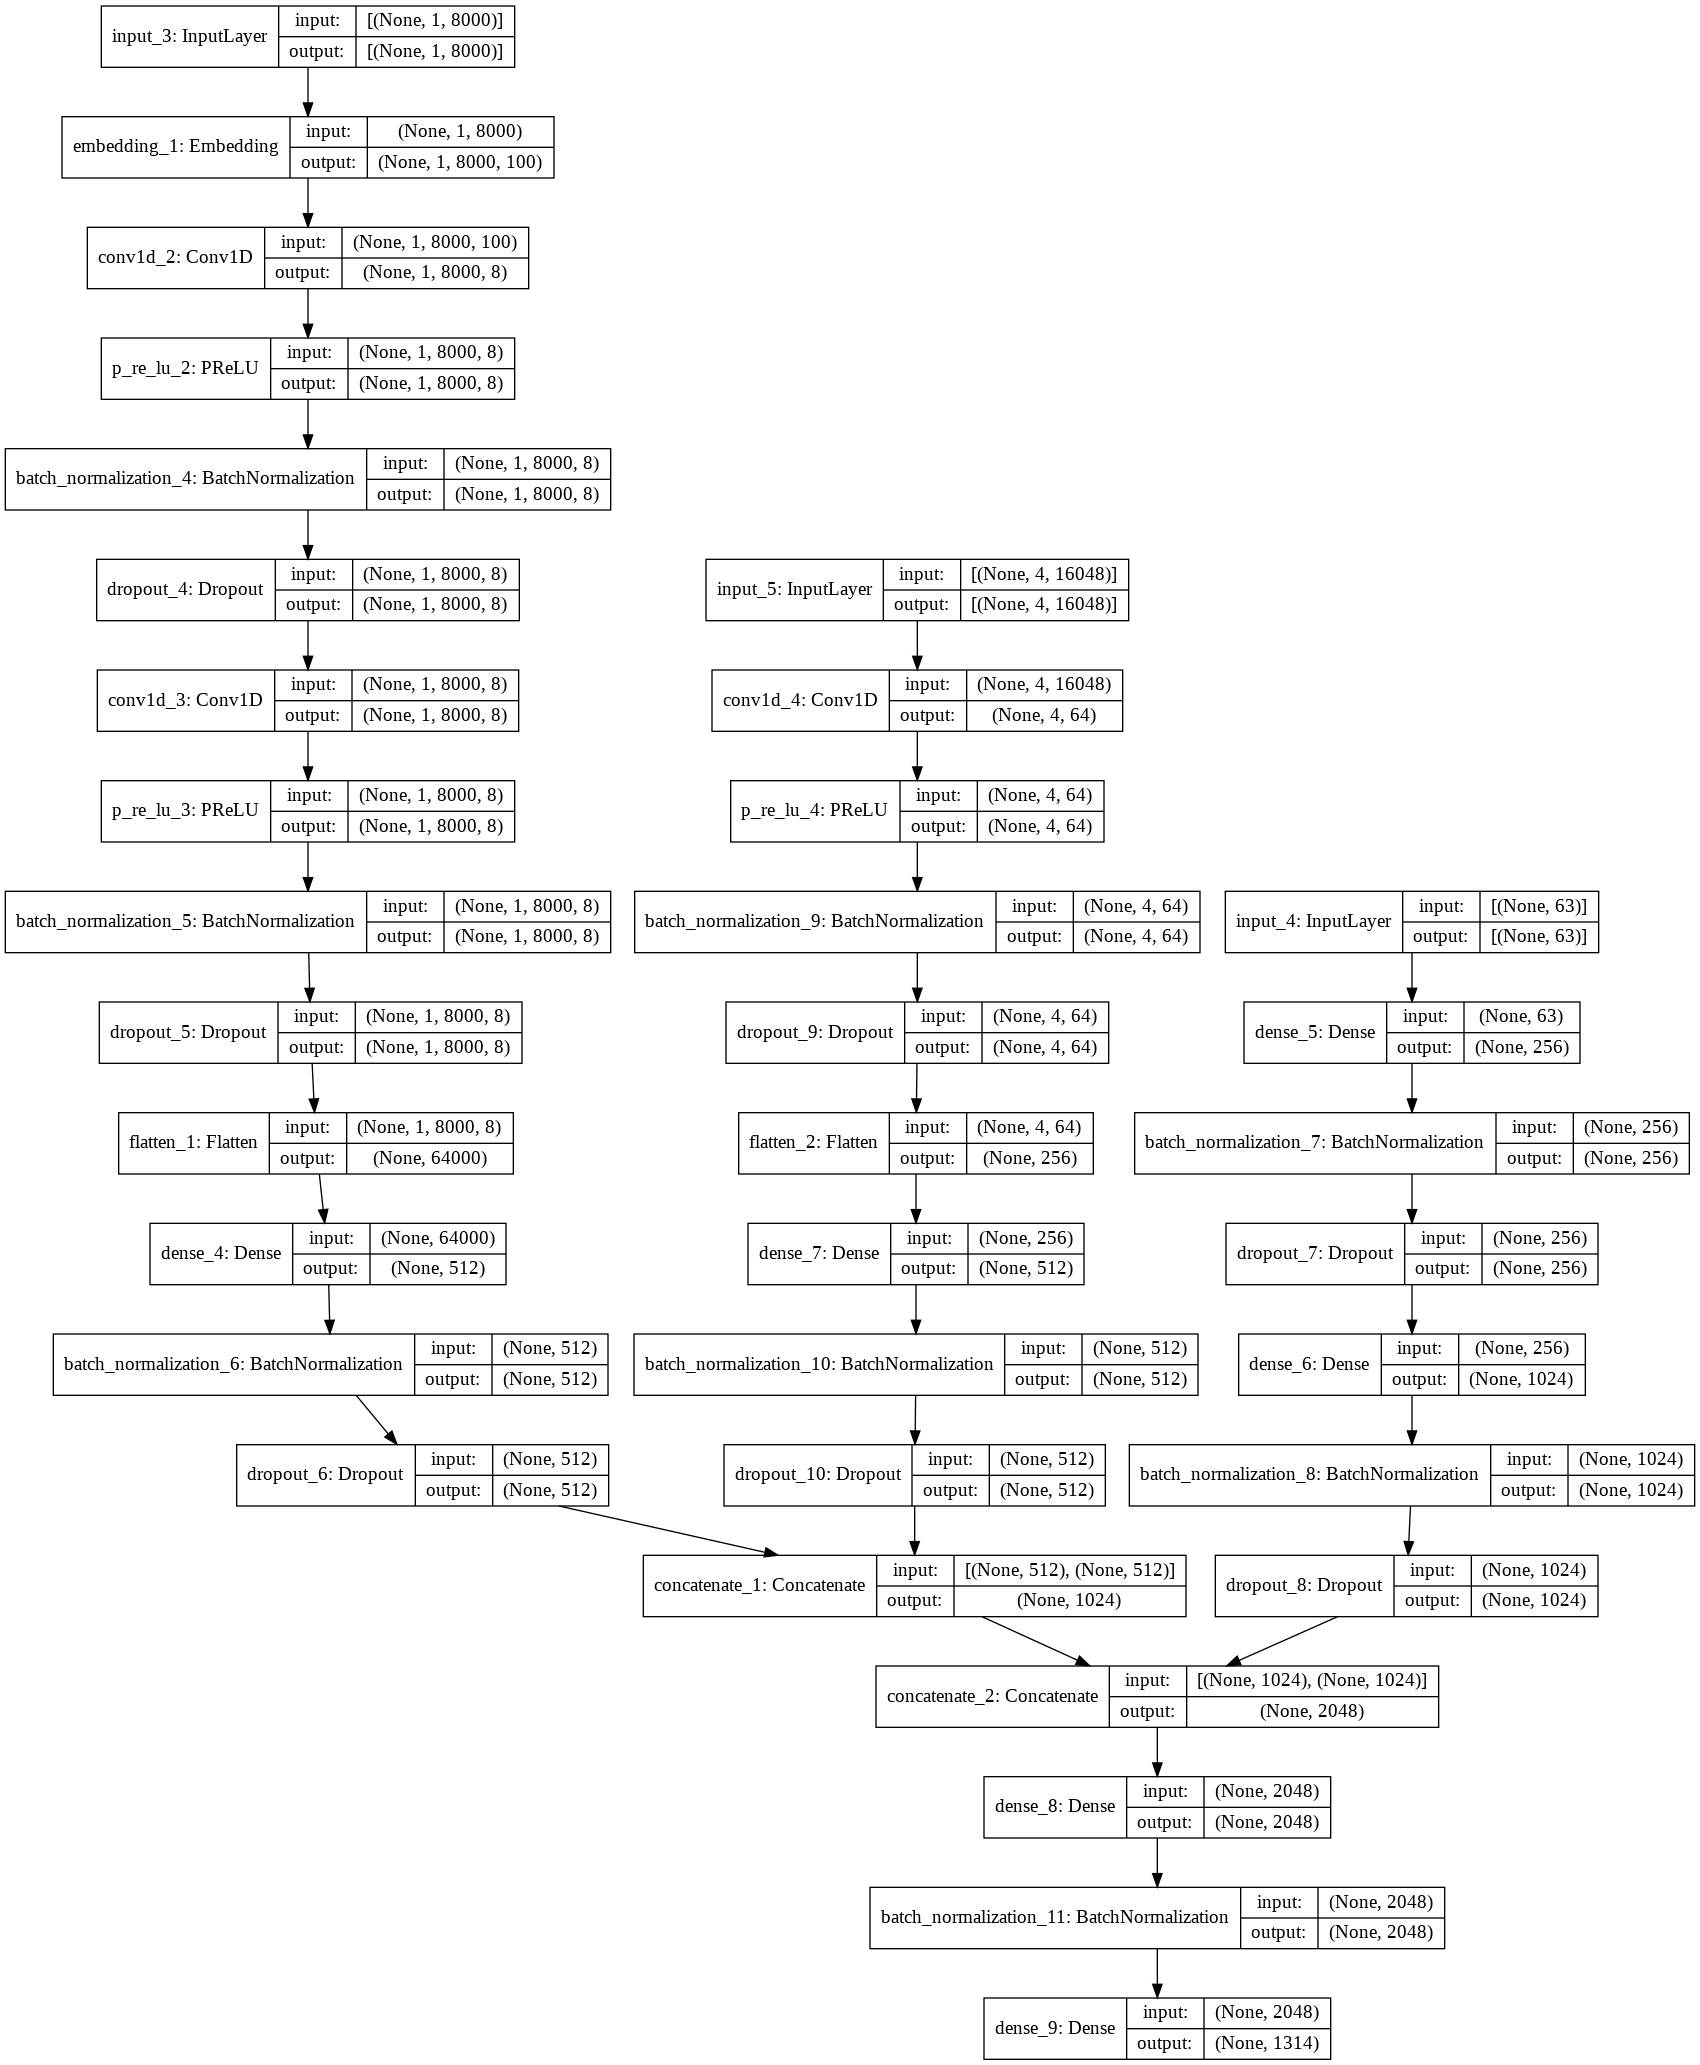

In [19]:
plot_model(mlp, show_shapes=True, show_layer_names=True)


In [20]:
sub=pd.DataFrame(output,columns=submission.columns[1:])
sub=pd.concat([submission[['sequence_id']],sub],axis=1)
sub=reduce_mem_usage(sub)

Memory usage of dataframe is 188.77 MB
Memory usage after optimization is: 47.96 MB
Decreased by 74.6%


In [ ]:
from google.colab import files
sub.to_csv("gene.csv",index=None)
files.download('gene.csv')

In [ ]:
sub

,sequence_id,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,0CML4B5I,0DTHTJLJ,0FFBBVE1,0HWCWFNU,0L3Y6ZB2,0M44GDO8,0MDYJM3H,0N3V9P9M,0NP55E93,0PJ91ZT6,0R296F9R,0T2AZBD6,0URA80CN,0VRP2DI6,0W6O08VX,0WHP4PPK,0XPTGGLP,0XS4FHP3,0Y24J5G2,10TEBWK2,11TTDKTM,131RRHBV,13LZE1F7,14PBN8C2,15D0Z97U,15S88O4Q,18C9J8EH,19CAUKJB,1AP294AT,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
0,E0VFT,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.960464e-08,5.960464e-08,0.000000e+00,0.000000e+00,0.000000e+00,5.960464e-08,0.000000e+00,0.0,0.0,0.0,0.000000e+00,5.960464e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.960464e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.960464e-08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.192093e-07,5.960464e-08,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.788139e-07,0.000000e+00,0.000000e+00,4.470348e-06,0.000000,0.0,0.000000e+00,0.000000e+00,5.960464e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.072884e-06
1,TTRK5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2Z7FZ,0.000000e+00,5.960464e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.072884e-06,7.873774e-05,0.000000e+00,5.960464e-08,5.960464e-08,4.172325e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,2.384186e-07,1.010299e-04,1.633167e-04,0.000000e+00,2.384186e-07,5.960464e-08,5.960464e-08,2.980232e-07,1.788139e-07,5.960464e-08,0.000000e+00,0.000000e+00,1.788139e-07,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000015,0.000000e+00,0.0,5.960464e-08,5.960464e-08,...,4.768372e-07,0.000000e+00,0.000000e+00,3.576279e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.960464e-08,0.000000e+00,9.477139e-06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3.755093e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.450581e-06,0.000004,0.0,0.000000e+00,0.000000e+00,5.960464e-08,0.000000e+00,6.139278e-06,1.013279e-06,2.384186e-07,0.000000e+00,0.000000e+00,1.418591e-05
3,VJI6E,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.624756e-01,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.192093e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0000